
**Detection of Persuasion Techniques in Texts and Images**

Subtask 3 (ST3) Given a meme, identify which techniques (out of 22 possible ones) are used in the meme, considering both the text and the image. This is a multi-label classification problem

**Model and Architecture**

A BERT-like architecture known as supervised MultiModal BiTransformers (MMBT) is built on unimodally pretrained text transformers and picture encoders that are then refined in a combined modality by projecting the visual embeddings onto the text token space
A transformer model is used in multimodal settings to combine text and image to make predictions.The final activations of a pretrained on image resnet (after the pooling layer) that travels via a linear layer and the embeddings of the tokenized text are supplied into the transformer model (to go from number of features at the end of the resnet to the hidden state dimension of the transformer). The various inputs are integrated, and to inform the model which portion of the input vector pertains to the text and which to the image, a segment embedding is added on top of the positional embeddings.
It helps in the classification task.

There are various steps involved in the process

1.   We first train the randomly initialised components
2.   Image encoder is trained using pretrained resnet50
3.   Fine tuning is performed

**Evaluation Metric**
We'll evaluate our performance using the metrics Micro and Macro F1 Scores.
The reason for choosing this is that our problem is multi-label classification.

**Uncomment and run the below block of code to install the required packages**

In [1]:
 ! pip install  "datasets" "transformers" "pytorch-lightning"
 !pip install torchmetrics==0.8.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importing all the required libraries**

In [2]:
import torch
from torch.utils.data import (Dataset,DataLoader,)
import torch.nn as nn
import torchmetrics
from pytorch_lightning import (LightningDataModule, LightningModule,Trainer)
from pytorch_lightning.callbacks.base import Callback
from transformers import (AdamW,AutoConfig,AutoModel,AutoTokenizer,MMBTModel,MMBTConfig)
from torchvision import transforms, models
from PIL import Image
import csv
import json
import re
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

**Mounting the drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loss Function**

The loss function being used is the Focal Loss.

By giving harder or more easily misclassified samples (such as backgrounds with noisy textures, incomplete objects, or the object of our interest) more weight and de-weighting easy examples, Focal Loss (FL), an improved form of Cross-Entropy Loss (CE), aims to address the class imbalance problem (i.e. Background objects).

*FL (pt) = -αt(1-  pt)^γ log(log(pt))*

The rate at which simple instances are down-weighted is smoothly adjusted by the focussing parameter γ.

In [4]:
class FocalLoss(nn.Module):
    def __init__(self, gamma_value=2):
        super(FocalLoss, self).__init__()
        self.gamma_value = gamma_value
        #binary cross entropy loss with logit loss is sigmoid loss + binary cross entropy loss
        self.loss = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, labels):
        #-αt(1-  pt)^γ*log(pt)
        #taking sigmoid
        alpha = torch.sigmoid(logits)
        #calculating the value of model's estimated probability
        p_t = alpha*labels + (1. - alpha)*(1. - labels)
        #applying the formula
        loss_tensor = ((1-p_t)**self.gamma_value) * (self.loss(logits, labels))
        #mean value of all elements in the input tensor
        mean_val = torch.mean(loss_tensor)
        #returning the mean value
        return mean_val

**Callback function to get results at the end of training**

In [5]:
class EvaluateCallback(Callback):
    """When training ends"""
    def on_fit_end(self, trainer, model):
        print("Training results")
        #getting values for model predictions and labels and printing the results
        self.get_values(model)
        #get predictions and labels
        model.predictions = torch.Tensor()
        model.labels = torch.Tensor()
        return
    """When testing ends"""
    def on_test_end(self, trainer, model):
        print("Test results")
        #getting values for model predictions and labels and printing the results
        self.get_values(model)
        #get predictions and labels
        model.predictions = torch.Tensor()
        model.labels = torch.Tensor()
        return
    
    """Function to get values of model predictions and labels"""
    def get_values(self,model):
        model_predictions = model.predictions.int()
        model_labels = model.labels.int()
        self.print_results(model_predictions, model_labels,model.mlb.classes_,model.classes,1)
        return

    """function to returns a new Tensor, detached from the current computational graph"""
    def get_prediction_label(self,predictions, labels,):
        predictions = predictions.detach().cpu() 
        labels = labels.detach().cpu()
        return predictions,labels
    
    """function to plot confusion matrix"""
    def plot_confusion_matrix(self,conf_mat,num_classes,title):
        classes=['negative', 'positive'] 
        fig, ax = plt.subplots()
        im = ax.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.GnBu)
        ax = self.set_params_subplot(conf_mat,ax,im,num_classes,title)
        fig.tight_layout()

    """function to plot confusion matrix for all the specified techniques"""
    def plot_cm_for_allTechniques(self,confusion_matrices, classes):
        label =0
        for cm in confusion_matrices:
          title="Confusion matrix for " + str(classes[label])
          self.plot_confusion_matrix(cm,2,title)
          print()
          label += 1

    """function to set parameter values for subplot"""
    def set_params_subplot(self,conf_mat,ax,im,num_classes,title):
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(conf_mat.shape[1]),yticks=np.arange(conf_mat.shape[0]),title=title,
               yticklabels=['negative', 'positive'],ylabel='True label',xlabel='Predicted label')
        ax.set_ylim(num_classes-0.5, -0.5)

        prob = conf_mat.max() / 2
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                ax.text(j, i, format(conf_mat[i, j], 'd'),ha="center", va="center",color="black")
        return ax

    """Funtion to print the results of micro and macro f1 scores"""
    def print_results(self, predictions, labels, classes, num_classes,zero_division):
        predictions,labels = self.get_prediction_label(predictions, labels,)
        print("F1-micro: {}".format(f1_score(labels,predictions, average="micro", zero_division=zero_division)))
        print("F1-macro: {}".format(f1_score(labels,predictions, average="macro", zero_division=zero_division)))
        #A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True and how many are False. 
        print(classification_report(labels, predictions, labels=[i for i in range(num_classes)], target_names=classes, zero_division=zero_division))
        #printing the confusion matrix
        torchmetrics_cm = torchmetrics.ConfusionMatrix(num_classes=num_classes, multilabel=True)
        conf_mat = torchmetrics_cm(predictions,labels)
        self.plot_cm_for_allTechniques(conf_mat, classes)
        return

**Setting the dataset attributes**

Each data item has the following attributes
input_ids

*   attention_masks
*   input_modal 
*   modal_start_tokens
*   modal_end_tokens            
*   labels

**Dataset** allows you to use pre-loaded datasets as well as your own data

In [6]:
class Dataset_(Dataset):
    def __init__(self,sent,att_mask,image,start,end,y_labels):
        self.sent = sent
        self.att_mask = att_mask
        self.image = image
        self.start = start 
        self.end = end
        self.y_labels = y_labels
    
    def __len__(self):
        return len(self.y_labels)
    
    def __getitem__(self, index):
        sent,att_mask,image,start,end,y_labels = self.get_values(index)
        sample = {
            "input_ids": sent, 
            "attention_mask": att_mask,
            "input_modal": image, 
            "modal_start_tokens": start,
            "modal_end_tokens": end, 
            "labels": y_labels
            }
        return sample
    def get_values(self,index):
        sent = self.sent[index]
        att_mask = self.att_mask[index]
        image = self.image[index]
        start = self.start
        end = self.end
        y_labels = self.y_labels[index]
        return sent,att_mask,image,start,end,y_labels

**Code for the DATA MODULE**

A DataModule standardizes the training, val, test splits, data preparation and transforms. The main advantage is consistent data splits, data preparation and transforms across models.

class DataModule(LightningDataModule):

  def __init__(self):
      
      super().__init__()

  def prepare_data(self):

        # download, split, etc...
        # only called on 1 GPU/TPU in distributed

  def setup(self, stage):

        # make assignments here (val/train/test split)
        # called on every process in DDP

  def train_dataloader(self):

        train_split = Dataset(...)
        return DataLoader(train_split)

  def val_dataloader(self):

        val_split = Dataset(...)
        return DataLoader(val_split)

  def test_dataloader(self):
  
        test_split = Dataset(...)
        return DataLoader(test_split)

In [7]:
class DataModule(LightningDataModule):
    """Initialising all the values"""
    def __init__(self,traindir,data_train,testdir,data_test,valdir,data_val,techniques,model_name,batch_size,**kwargs,):
        super().__init__()
        self.traindir = traindir
        self.data_train = data_train
        self.test_directory = testdir
        self.data_test = data_test
        self.valdir = valdir
        self.data_val = data_val
        self.techniques = techniques
        self.batch_size = batch_size
        self.num_classes = 22
        #AutoTokenizer is a generic tokenizer class
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
        #MultiLabelBinarizer converts input labels into multilabel labels, each example can belong to multiple classes
        self.MultiLB = MultiLabelBinarizer()
        #torchvision.transforms.Compose(transforms) Composes several transforms together
        self.transforms = self.transform_()

    def transform_(self):
        #list of mean and standard deviation values
        mean_vals = [0.485, 0.456, 0.406]
        std_vals = [0.229, 0.224, 0.225]

        trans = transforms.Compose([
            transforms.Resize(256),       #Resize the input image to the given size
            transforms.CenterCrop(224),   #Crops the given image at the center
            transforms.ToTensor(),        #Convert a PIL Image or numpy.ndarray to tensor. 
            transforms.Normalize(mean=mean_vals, std=std_vals)    #This normalizes the tensor image with mean and standard deviation
        ])
        return trans

    """Function to compute the values of X and Y training samples"""
    def training_(self,X_train):
        #preprocessing the data
        self.X_train_enc, self.X_train_attention = self.data_preprocessing(X_train)
        #applying MultiLabelBinarizer
        self.MultiLB.fit(self.techniques)
        #transforming the given input to tensor
        y_train = self.transform_to_tensor(self.data_train.labels.values)
        #converting the labels to tensor
        self.y_train = torch.tensor(y_train)
        #getting the image values
        train_imgs = self.data_train.image.values
        #performing image pre-processing
        self.X_train_images = self.Image_preprocessing(self.traindir, train_imgs)
        #returning the values
        return self.X_train_enc, self.X_train_attention,self.y_train,self.X_train_images
    
    """Function to compute the values of X and Y validation samples"""
    def validation_(self,X_val):
        #preprocessing the data
        self.X_val_enc, self.X_val_attention = self.data_preprocessing(X_val)
        #transforming the given input to tensor
        y_val = self.transform_to_tensor(self.data_val.labels.values)
        #converting the labels to tensor
        self.y_val = torch.tensor(y_val)
        #getting the image values
        validation_imgs = self.data_val.image.values
        #performing image pre-processing
        self.X_val_images = self.Image_preprocessing(self.valdir, validation_imgs)
        #returning the values
        return self.X_val_enc, self.X_val_attention,self.y_val, self.X_val_images

    """Function to compute the values of X and Y testing samples"""
    def testing_(self,X_test):
        #preprocessing the data
        self.X_test_enc, self.X_test_attention = self.data_preprocessing(X_test)
        #transforming the given input to tensor
        y_test = self.transform_to_tensor(self.data_test.labels.values)
        #converting the labels to tensor
        self.y_test = torch.tensor(y_test)
         #getting the image values
        test_imgs = self.data_test.image.values
        #performing image pre-processing
        self.X_test_images = self.Image_preprocessing(self.test_directory, test_imgs)
        #returning the values
        return self.X_test_enc, self.X_test_attention,self.y_test,self.X_test_images

    """This function is sued to perform the setup by initialising all the values"""
    def setup(self,stage: str = None):
        #getting the data values
        self.X_train = self.data_train.text.values
        self.X_test = self.data_test.text.values
        self.X_val = self.data_val.text.values
        #getting the maximum length
        self.max_length = self.maximum_length()
        #getting the token values
        self.start_token,self.end_token = self.get_encoded_tokens()
        #training
        self.X_train_enc, self.X_train_attention,self.y_train,self.X_train_images = self.training_(self.X_train)
        #test
        self.X_test_enc, self.X_test_attention,self.y_test,self.X_test_images = self.testing_(self.X_test)
        #validation
        self.X_val_enc, self.X_val_attention,self.y_val, self.X_val_images = self.validation_(self.X_val)
    
    """function to convert a label of multilabelbinrizer to a tensor"""
    def transform_to_tensor(self,label_val):
        transform = self.MultiLB.transform(label_val)
        return torch.tensor(transform)

    """Function to call the data loader for the training data sample for a particluar batch size"""
    def train_dataloader(self):
        data = Dataset_(self.X_train_enc, self.X_train_attention,self.X_train_images, self.start_token, self.end_token, self.y_train)
        train_dataloader = DataLoader(data, batch_size=self.batch_size)
        return train_dataloader

    """Function to call the data loader for the validation data sample for a particluar batch size"""
    def val_dataloader(self):
        data = Dataset_(self.X_val_enc, self.X_val_attention,self.X_val_images, self.start_token, self.end_token, self.y_val)
        val_dataloader = DataLoader(data, batch_size=self.batch_size)
        return val_dataloader
    
    """Function to call the data loader for the testing data sample for a particluar batch size"""
    def test_dataloader(self):
        data = Dataset_(self.X_test_enc, self.X_test_attention,self.X_test_images, self.start_token, self.end_token, self.y_test)
        test_dataloader = DataLoader(data, batch_size=self.batch_size)
        return test_dataloader

    """function to call auto-tonenizer on the given sentence and encode it"""
    def get_encoded(self,sentence,tokens):
        return self.tokenizer.encode(text=sentence,add_special_tokens=tokens)
    
    """function to replace characters in the sentence so it becomes easier to process
      remove \\ and replace \n with a space"""
    def replace_string(self,sent):
        return sent.replace('\\', "").replace('\n', ' ').strip()

    """function to return the encoded sentence"""
    def get_encoded_sentence(self,item):
        #calling the function to replace the characters in the sentence
        preprocessed_sent = self.replace_string(item)
        #encoding the sentence
        encoded_sent = self.get_encoded(preprocessed_sent,False)
        return encoded_sent

    """function to perform pre-processing on a given sentence"""
    def pre_process_sentence(self,item):
        #intialising lists to store the sentence and its attention mask
        sentence = [0] * self.max_length
        attention_mask = [0] * self.max_length
        #encoding the sentence
        encoded_sent = self.get_encoded_sentence(item)
        #calculating length of the encoded sentence
        lenn = len(encoded_sent)
        sentence[:lenn] = encoded_sent
        attention_mask[:lenn] = [1] * lenn
        #returning the sentence and its attention mask
        return sentence,attention_mask

    """function to perform data pre-processing given a complete sentence"""
    def data_preprocessing(self, data):
        #intialising lists
        sentences = []
        attentionMasks = []
        #for all the words in sentence
        for item in data:
            #pre-processing the sentence
            sentence,attention_mask = self.pre_process_sentence(item)
            #adding the output to the lists
            sentences.append(sentence)
            attentionMasks.append(attention_mask)
        #converting to tensors and returning
        return torch.tensor(sentences), torch.tensor(attentionMasks)

    """function to get token values for dummy case"""
    def get_encoded_tokens(self):
        sent = "dummy"
        #encoding the sentence
        encoded_sent = self.get_encoded(sent,True)
        #returning encoded tokens
        return encoded_sent[0], encoded_sent[-1]

    """function to concatenate the training, validation and testing data"""
    def train_test_val(self):
        #concatenating the training and testing data
        train_n_test = np.concatenate([self.X_train, self.X_test])
        #concatenating the validation data to above
        allX = np.concatenate([train_n_test, self.X_val])
        #returning the concatenated numpy array
        return allX

    """function to encode the given complete dataset(train+val+test)"""
    def get_encoded_X(self,allX):
        encoded_X=[]
        for sentence in allX:
          encoded_X.append(self.get_encoded(sentence,True))
        return encoded_X
    
    """function to get the list of length of sentences in complete encoded datset(train+val+test)"""
    def get_len_encodedX(self,encoded_X):
        maxLen = []
        for sentence in encoded_X:
          maxLen.append(len(sentence))
        return maxLen

    """function to get maximum length of sentence from complete encoded datset(train+val+test)"""
    def maximum_length(self):
        #merging the datsets together
        allX = self.train_test_val()
        #encoding the dataset
        encoded_X = self.get_encoded_X(allX)
        #finding the maximum length
        maxLen = max(self.get_len_encodedX(encoded_X))
        return maxLen

    """function to get the list of all the images for a specified path"""
    def get_image_list(self,directory_ ,image_path):
        images = []
        for path in image_path:
            #opening the image in the given directory path
            image = Image.open(directory_ + path)
            #transorm image
            image = self.transforms(image)
            #add to list
            images.append(image)
        return images

    """function to perform image pre-processing"""
    def Image_preprocessing(self, directory_ , image_path):
        images = self.get_image_list(directory_ ,image_path)
        #joins (concatenates) a sequence of tensors (two or more tensors) along a new dimension
        return torch.stack(images)

In [8]:
"""function to get all the data values and the path to image directories"""
def get_DatanPath(PATH):
  #training
  train_path = PATH + "training_set_task3/"
  train_txt = train_path + "training_set_task3.txt"
  train_data = pd.read_json(train_txt)
  #test
  test_path = PATH + "test_set_task3/"
  test_txt =test_path + "test_set_task3.txt"
  test_data = pd.read_json(test_txt)
  #development
  dev_path = PATH + "dev_set_task3_labeled/"
  dev_txt = dev_path + "dev_set_task3_labeled.txt"
  dev_data = pd.read_json(dev_txt)

  return train_data,dev_data,test_data,train_path,dev_path,test_path

In [9]:
#list of all the persuasion techniques used in the dataset
persuasion_techniques = [['Appeal to authority', 'Bandwagon','Appeal to fear/prejudice', 'Doubt','Appeal to (Strong) Emotions', 'Loaded Language',
               'Black-and-white Fallacy/Dictatorship','Causal Oversimplification', 'Repetition', 'Exaggeration/Minimisation', 'Slogans',
               'Flag-waving','Smears', 'Glittering generalities (Virtue)','Whataboutism','Name calling/Labeling',
               "Misrepresentation of Someone's Position (Straw Man)",'Presenting Irrelevant Data (Red Herring)',
               'Obfuscation, Intentional vagueness, Confusion','Reductio ad hitlerum','Transfer','Thought-terminating cliché']]

**Displaying some sample images**

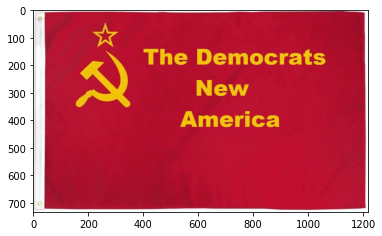

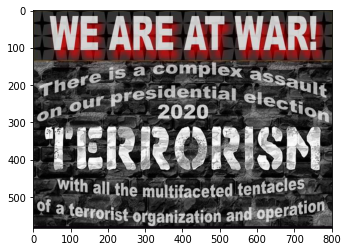

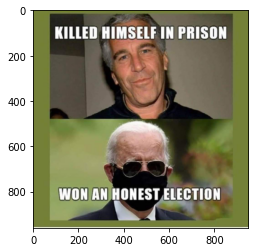

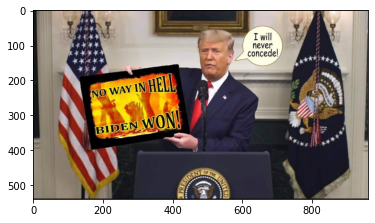

In [10]:
#getting all the parameter values
train_data,dev_data,test_data,train_path,dev_path,test_path = get_DatanPath(PATH)
texts = test_data.text.values
labels_data = test_data.labels.values
images = test_data.image.values
for i in range(4):
    img = Image.open(test_path + images[i])
    plt.imshow(img)
    plt.show()

In [11]:
#calling the DataModule to intitialse the data values
data_mod = DataModule(train_path, train_data,test_path, test_data,dev_path, dev_data,persuasion_techniques,"bert-base-cased",8)
#this is the pretrained transformer "bert-base-cased"
#setting up the data module
data_mod.setup()

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


**Initialising the Image Module class**

The torchvision.models subpackage contains definitions of models for addressing different tasks we'll be using it for the classification task.

We'll be using the **Resnet50** model trained on ImageNet

In [12]:
class ImageModule(nn.Module):
    def __init__(self):
        super().__init__()
        model_child = self.call_pretrained_resnet50()
        self.model = nn.Sequential(*model_child)
        #Applies a 2D adaptive average pooling over an input signal composed of several input planes
        self.pool = nn.AdaptiveAvgPool2d(2)

    def call_pretrained_resnet50(self):
      model = models.resnet50(pretrained=True)
      child = list(model.children())[:-2]
      return child

    """function to flatten the tensor into a one-dimensional tensor by reshaping it"""
    def flatten(self,dim):
        return torch.flatten(dim,start_dim=2)
    
    """returns the transpose"""
    def transpose_(self,dim):
        #contiguous()makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from
        t = dim.transpose(1, 2).contiguous()
        return t

    """function to do the parameter passing and computation"""
    def forward(self, x):
        return_dim = self.pool(self.model(x))
        return_dim = self.flatten(return_dim)
        return_dim = self.transpose_(return_dim)
        return return_dim

**Model Working**

A LightningModule organizes your PyTorch code into 6 sections:

* Computations (init).

* Train Loop (training_step)

* Validation Loop (validation_step)

* Test Loop (test_step)

* Prediction Loop (predict_step)

* Optimizers and LR Schedulers (configure_optimizers)

Lightning handles the distributed sampler for you by default. It helps in improving code readibility and performance.

**Model is the MultiModel BiTransformer (MMBT)**

We are using **AdamW** optimizer because AdamW produces better training loss and the models generalise significantly better than models trained with Adam.

In [13]:
train_loss = []
val_loss = []
class Model(LightningModule):
    """initialising all the required parameter values"""
    def __init__(self,mlb,model_name,classes,batch_size,learning_rate,epsilon,weight_decay,**kwargs,):
        super().__init__()
        #hyperparameter values
        self.mlb = mlb
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.save_hyperparameters()
        self.classes = classes
        #creating a transformer, that is a model that is an instance of BertModel. 
        self.transformer = AutoModel.from_pretrained(model_name, config=self.config_model(model_name))
        #calling the image module
        self.image_encoder = ImageModule()
        #getting the multimodal bitransfomer
        self.model = self.get_MMBT_model(model_name,self.transformer,self.image_encoder)
        #initialising the loss function
        self.loss = FocalLoss()
        self.threshold = 0.5
        #getting the accuracy measure
        self.accuracy = torchmetrics.Accuracy()
        #registering the buffer
        self.register_buffer = self.registerr_buffer()
        #setting the layers
        self.layers = self.sequential_layers()

    """function to get the layers"""
    def sequential_layers(self):
        #A sequential container.Modules will be added to it in the order they are passed in the constructor.
        layers = nn.Sequential(nn.Linear(768, 64),nn.ReLU(),nn.Dropout(0.1),nn.Linear(64,22))
        return layers

    """function to return the configured MMBT model"""
    def get_MMBT_model(self,model,transformer,iencoder):
        return MMBTModel(self.config_MMBT(model),transformer,iencoder)

    """function to register buffer for labels and predictions"""
    def registerr_buffer(self):
        self.register_buffer("labels", torch.Tensor())
        self.register_buffer("predictions", torch.Tensor())
        return self.register_buffer

    """function to configure the pretrained resnet50 model"""
    def config_model(self,model_name):
        return AutoConfig.from_pretrained(model_name)

    """function to configure the MMBT model"""
    def config_MMBT(self,model_name):
        con = self.config_model(model_name)
        return MMBTConfig(con)

    """function to get output from the hidden layer"""
    def get_hidden_output(self,out):
        ret = out.last_hidden_state[:, 0, :]
        return ret

    """function to do the parameter passing and computation"""
    def forward(self, **inputs):
        output = self.model(**inputs)
        hid_out = output.last_hidden_state[:, 0, :]
        ret = self.layers(hid_out)
        return ret

    """function to get data values for a particular batch"""
    def get_batch_input(self,batch):
        batch_input = {
            "input_ids": batch["input_ids"],
            "attention_mask": batch["attention_mask"],
            "input_modal": batch["input_modal"],
            "modal_start_tokens": batch["modal_start_tokens"],
            "modal_end_tokens": batch["modal_end_tokens"],
            "return_dict": True
        }
        return batch_input

    """function to calculate loss which is focal loss in our case"""
    def calculate_loss(self,in_,labels):
        return self.loss(in_, labels.to(torch.float32))

    """function to get predictions"""
    def get_predictions(self,batch_in):
        #torch.sigmoid converts value in the range of 0-1
        #if the value is greater than 0.5 we convert it to int and return
        return (torch.sigmoid(batch_in) > self.threshold).int()

    """function to get accuracy based on the predicted label and actual label"""
    def get_accuracy(self,pred,labels):
        return self.accuracy(pred, labels)

    """function to compute the value of loss and accuracy for a particular batch"""
    def working(self,batch):
        #getting all the labels
        labels = batch["labels"]
        #getting the data values for the batch
        batch_input = self.get_batch_input(batch)
        batch_in = self(**batch_input)
        #calculating the loss value
        loss = self.calculate_loss(batch_in,labels)
        #finding the predictions
        pred = self.get_predictions(batch_in)
        #computing the accuracy
        accuracy = self.get_accuracy(pred, labels)
        return loss,accuracy
    
    """finding the loss and accuracy at training step"""
    def training_step(self,batch,batch_idx):
        loss,accuracy = self.working(batch)
        return {"loss": loss, "accuracy": accuracy}

    """finding the loss,accuracy,actual labels and predicted labels at validation step"""
    def validation_step(self,batch,batch_idx):
        #getting all the labels
        labels = batch["labels"]
        #getting the data values for the batch
        batch_input = self.get_batch_input(batch)
        batch_in = self(**batch_input)
        #calculating the loss value
        loss = self.calculate_loss(batch_in,labels)
        #finding the predictions
        pred = self.get_predictions(batch_in)
        accuracy = self.get_accuracy(pred, labels)
        #computing the accuracy
        return {"loss": loss, "accuracy": accuracy,"predictions": pred, "labels": labels}
    
    """concatenation function i.e val1 + val2"""
    def concat(self,in1,in2):
        return torch.cat((in1,in2), 0)

    """finding the loss,accuracy at test step"""
    def test_step(self, batch,batch_idx):
        #getting all the labels
        labels = batch["labels"]
        #getting the data values for the batch
        batch_input = self.get_batch_input(batch)
        batch_in = self(**batch_input)
        #calculating the loss value
        loss = self.calculate_loss(batch_in,labels)
        #finding the predictions
        pred = self.get_predictions(batch_in)
        #computing the accuracy
        accuracy = self.get_accuracy(pred, labels)
        #concatinating the labels and accuracy of train+val step with the test step 
        self.labels = self.concat(self.labels,labels)
        self.predictions = self.concat(self.predictions,pred)

        return {"loss": loss, "accuracy": accuracy}

    """function to get predictions
        torch.sigmoid converts value in the range of 0-1 if the value is greater than 0.5 we convert it to int and return"""
    def get_predictions_n_detach(self,in_):
        sig = (torch.sigmoid(in_) > self.threshold)
        ret = sig.int().detach().cpu().numpy()
        return ret

    """function to perform the prediction step"""
    def predict_step(self, batch, batch_idx):
        #getting the inpit data for batch
        batch_input = batch_input = self.get_batch_input(batch)
        b_in = self(**batch_input)
        #getting the predictions
        pred = self.get_predictions_n_detach(b_in)
        #Scale back the data to the original representation.
        inv = self.mlb.inverse_transform(pred)
        return inv

    """function to get labels at the end of validation epoch""" 
    def get_all_labels(self,out):
        ret = []
        for i in out:
            ret.append(i["labels"])
        return torch.cat(ret, dim=0)
    
    """function to get predictions at the end of validation epoch"""
    def get_all_predictions(self,out):
        ret = []
        for i in out:
            ret.append(i["predictions"])
        return torch.cat(ret, dim=0)
    
    """function to check if we have reached the maximum epoch to train"""
    def chech_if_maxEpoch(self):
        if(self.current_epoch == self.trainer.max_epochs - 1):
          return True
    
    """function to get loss at the end of training"""
    def training_epoch_end(self, outputs):
        loss = sum(output['loss'] for output in outputs) / len(outputs)
        train_loss.append(loss.item())

    """function to get labels and predictions when maximum epoch is reached otherwise get the loss value"""
    def validation_epoch_end(self, outputs):
        if self.chech_if_maxEpoch():
            self.labels = self.get_all_labels(outputs)
            self.predictions = self.get_all_predictions(outputs)
        else:
          loss = sum(output['loss'] for output in outputs) / len(outputs)
          val_loss.append(loss.item())

    """function to return the output at the end of validation step"""
    def validation_step_end(self, out):
        return out
    
    """function to get parameter values"""
    def get_params(self,condition):
        params = []
        decay = ["LayerNorm.weight","bias"]
        for name,param in self.named_parameters():
          if condition == 1:
            if not any(n_decay in name for n_decay in decay):
              params.append(param)
          if condition == 2:
            if any(n_decay in name for n_decay in decay):
              params.append(param)
        return params

    """function to get the value of weight hyperparameter"""
    def get_hyperParam_weight(self):
        return self.hparams.weight_decay
    
    """function to get the value of learning rate hyperparameter"""
    def get_hyperParam_lrate(self):
        return self.hparams.learning_rate
    
    """function to get the value of epsilon hyperparameter"""
    def get_hyperParam_epsilon(self):
        return self.hparams.epsilon

    """function to configure the optimizers"""
    def configure_optimizers(self):
        #getting the values of hyper parameters
        weight = self.get_hyperParam_weight()
        learning_rate = self.get_hyperParam_lrate()
        epsilon = self.get_hyperParam_epsilon()
        #setting the values of paramater and weigh decay
        optimizerParam = [{
                "params": self.get_params(1),"weight_decay": weight},{
                "params": self.get_params(2),"weight_decay": 0.0,},]
        #configuring AdamW optimizer
        optimizer = AdamW(optimizerParam,lr=learning_rate, eps=epsilon)
        return optimizer

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/base.py:23: LightningDeprecationWarning: pytorch_lightning.callbacks.base.Callback has been deprecated in v1.7 and will be removed in v1.9. Use the equivalent class from the pytorch_lightning.callbacks.callback.Callback class instead.
  "pytorch_lightning.callbacks.base.Callback has been deprecated in v1.7"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.util

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Training results
F1-micro: 0.5705329153605015
F1-macro: 0.23515605528806846
                                                     precision    recall  f1-score   support

                        Appeal to (Strong) Emotions       1.00      0.00      0.00         3
                                Appeal to authority       1.00      0.00      0.00         3
                           Appeal to fear/prejudice       1.00      0.00      0.00         7
                                          Bandwagon       1.00      0.00      0.00         2
               Black-and-white Fallacy/Dictatorship       1.00      1.00      1.00         0
                          Causal Oversimplification       1.00      0.00      0.00         1
                                              Doubt       1.00      0.00      0.00         9
                          Exaggeration/Minimisation       1.00      0.00      0.00         8
                                        Flag-waving       1.00      0.00      0.00    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


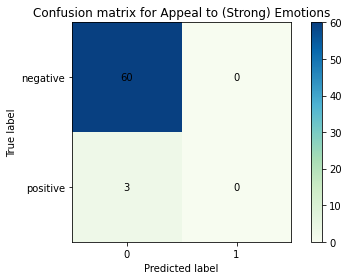

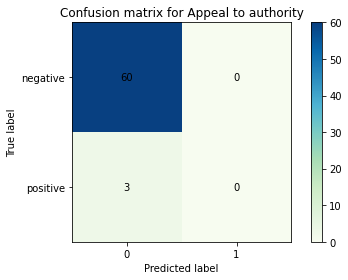

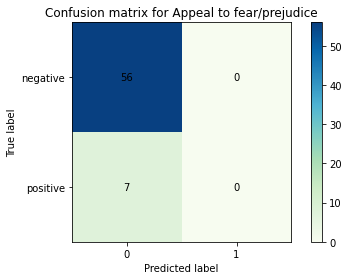

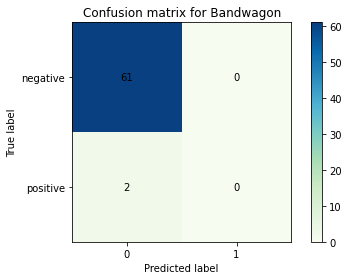

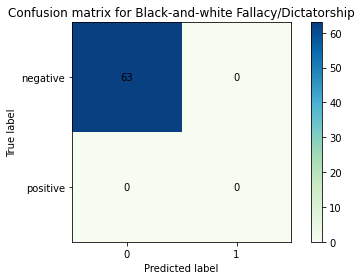

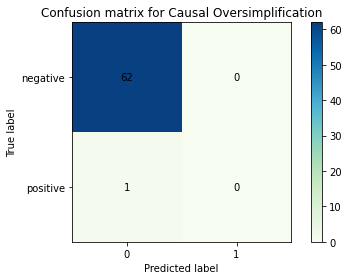

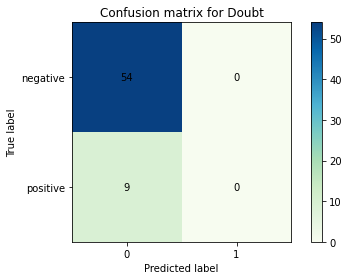

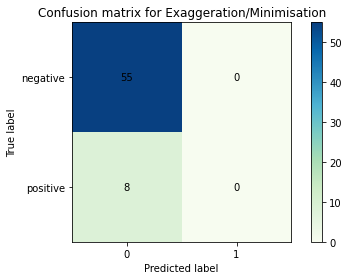

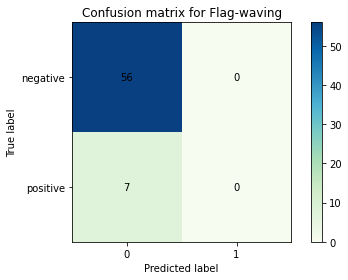

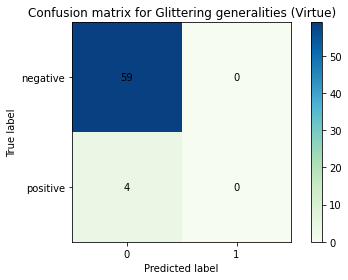

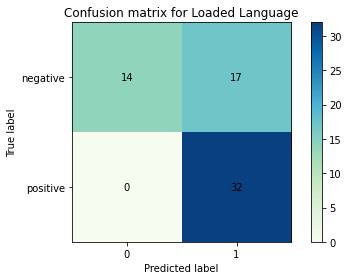

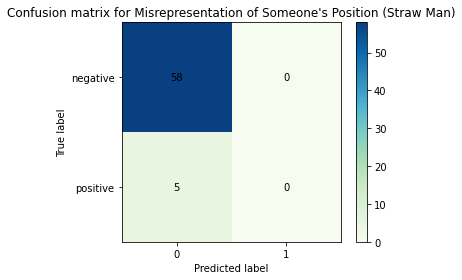

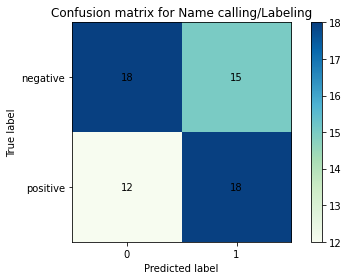

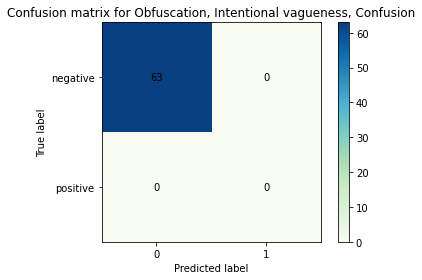

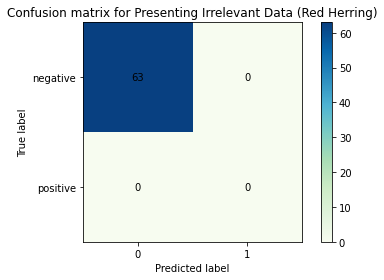

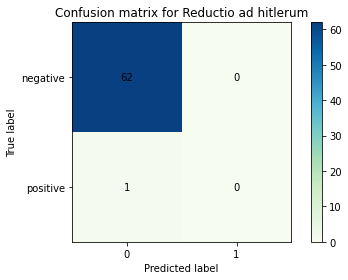

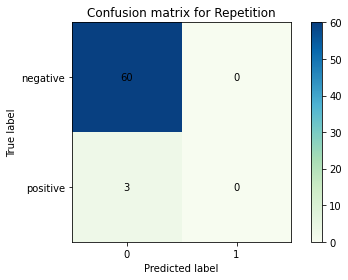

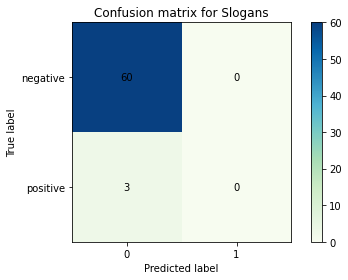

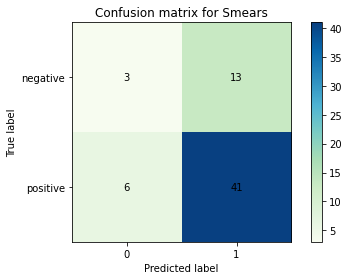

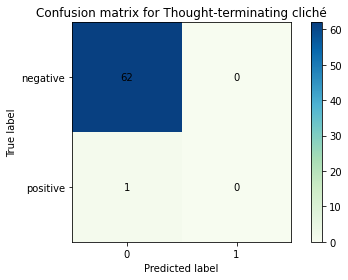

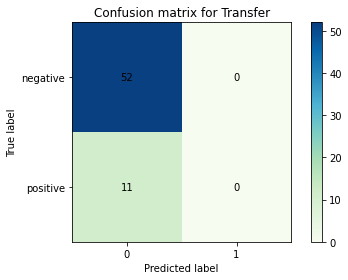

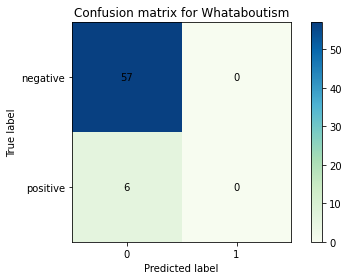

In [14]:
#initialising the model with the given parameters
model = Model(data_mod.MultiLB,"bert-base-cased",int(22),int(8),float(2e-5),float(1e-8),float(0.1))
#The Trainer class provides an API for feature-complete training
trainer = Trainer(max_epochs=10,gpus=1,callbacks=[EvaluateCallback()])
#fitting model for the given data module
trainer.fit(model, data_mod)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Test results
F1-micro: 0.47147470398277713
F1-macro: 0.08453686051455965
                                                     precision    recall  f1-score   support

                        Appeal to (Strong) Emotions       1.00      0.00      0.00        19
                                Appeal to authority       1.00      0.00      0.00        13
                           Appeal to fear/prejudice       1.00      0.00      0.00        18
                                          Bandwagon       1.00      0.00      0.00         1
               Black-and-white Fallacy/Dictatorship       1.00      0.00      0.00         7
                          Causal Oversimplification       1.00      0.00      0.00         4
                                              Doubt       1.00      0.00      0.00        41
                          Exaggeration/Minimisation       1.00      0.00      0.00        31
                                        Flag-waving       1.00      0.00      0.00       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[{}]

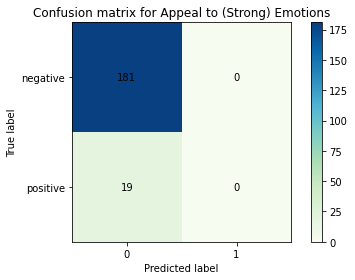

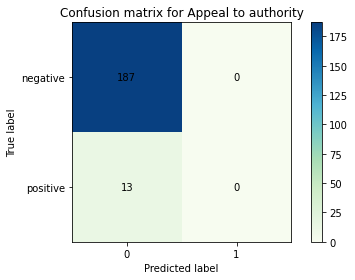

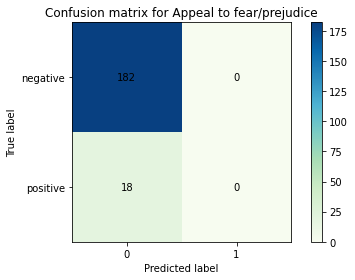

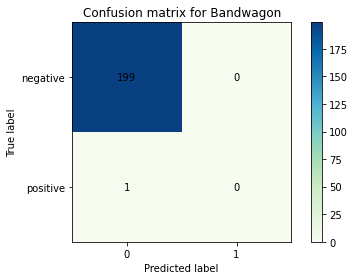

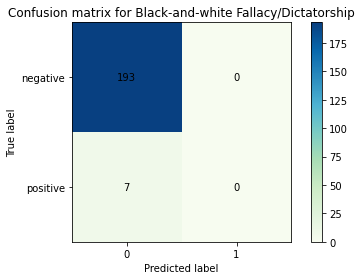

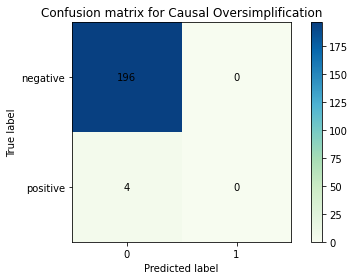

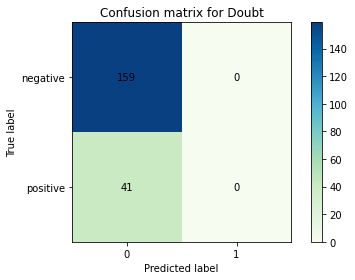

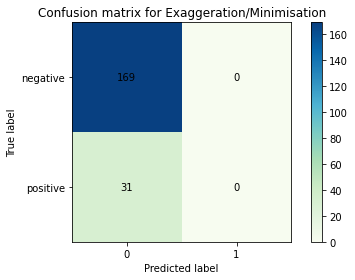

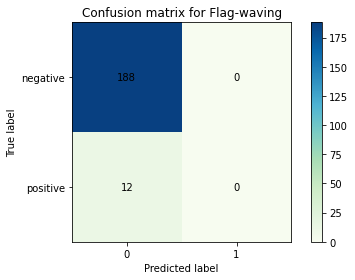

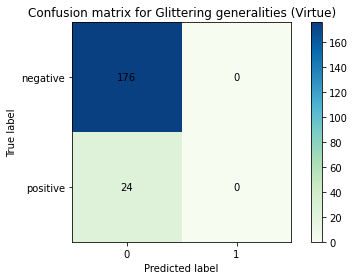

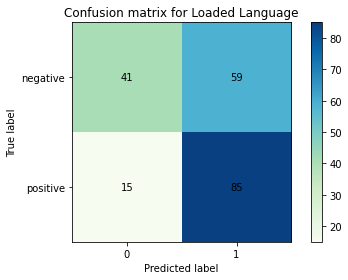

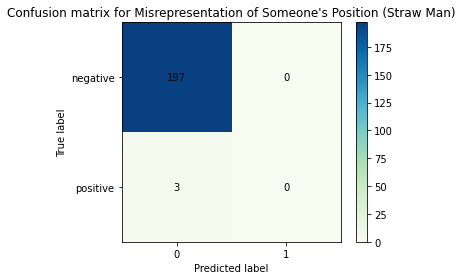

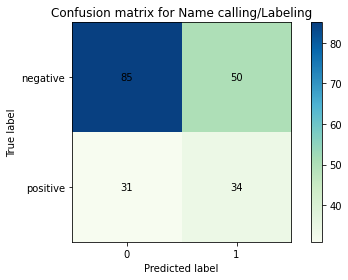

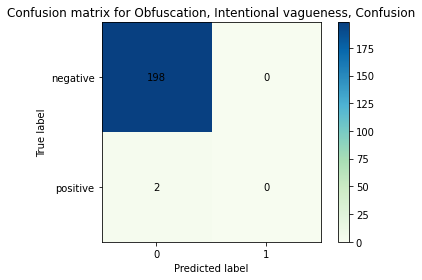

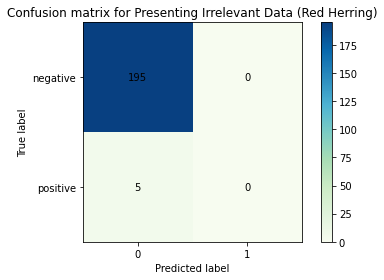

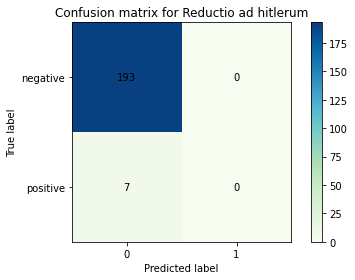

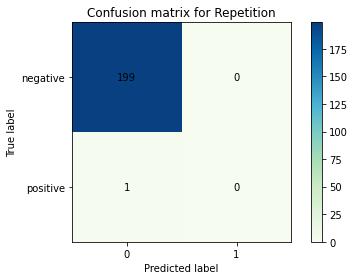

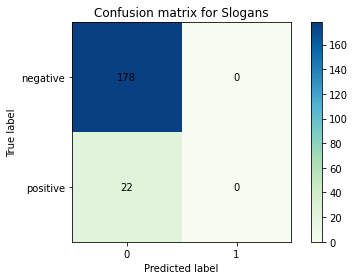

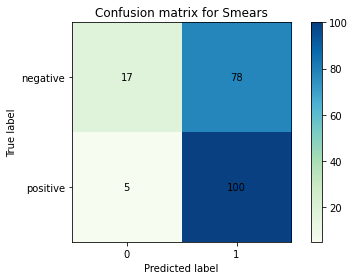

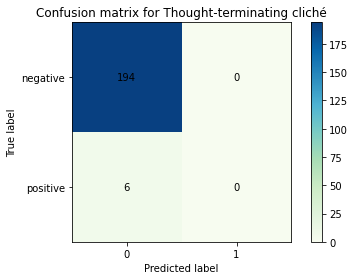

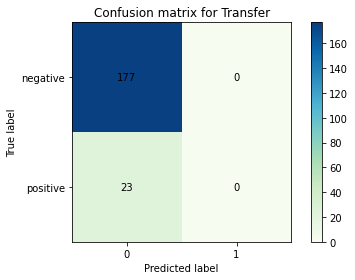

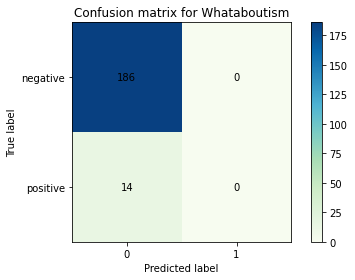

In [15]:
#testing the model for testing data
trainer.test(model, data_mod)

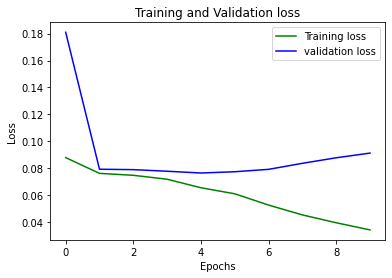

In [16]:
epochs = range(0,10)
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()